In [1]:
# generic imports 

from bydoux_tools import read_google_sheet_csv, get_info
import warnings
import numpy as np
from scipy.optimize import minimize
import bydoux_tools as bt
from astropy.time import Time,TimeDelta
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm
import matplotlib.cm as cm



In [2]:
# Parameters for the code that may change
force = True
verbose = False

t0 = Time('2023-03-01', format='iso').mjd
t1 = Time.now().mjd

In [3]:
# Fetch the disnat summary table of my accounts

tbl = bt.get_disnat_summary()
tbl = tbl[np.argsort(tbl['mjd'])]

In [4]:
# Construct a time span for the analysis (daily steps)
time_span = np.arange(t0, t1, 1)

tbl0 = Table()
tbl0['mjd'] = time_span

# Read S&P 500 and CAD/USD FX rate data
sp500 = bt.read_quotes('^SPX', force=force)
cadusd = bt.read_quotes('CADUSD=X', force=force)

# Interpolate CAD/USD and SP500 values onto the analysis time grid
tbl0['CADUSD'] = np.interp(tbl0['mjd'], cadusd['mjd'], cadusd['Close'])
tbl0['SP500'] = np.interp(tbl0['mjd'], sp500['mjd'], sp500['Close'])
tbl0['N_SP500'] = 0.0
tbl0['CONTRIBUTIONS'] = 0.0

# Also interpolate SP500 onto the transaction table for reference
tbl['SP500'] = np.interp(tbl['mjd'], sp500['mjd'], sp500['Close'])

# Compute running sum of contributions (COTISATION and TRANSFERT REÇU in CAD)
for i in tqdm(range(len(tbl)),leave = False, desc='Computing contributions'):
    if tbl['Devise du prix'][i] != 'CAN':
        continue
    if tbl['Type de transaction'][i] in ['COTISATION', 'TRANSFERT REÇU']:
        g = tbl0['mjd'] > tbl['mjd'][i]
        tbl0['CONTRIBUTIONS'][g] += tbl["Montant de l'opération"][i]

/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 8006 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 8006 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


In [5]:
# Get the symbol of all actions bought or sold: 'Type de transaction' is 'ACHAT' or 'VENTE'
# This block identifies all unique stock symbols that have been bought or sold in the transaction table.

flag = [
    ('ACHAT' in x or 'VENTE' in x)
    for x in tbl['Type de transaction']
]
symbols = np.unique(tbl[flag]['Symbole'])

quotes_dict = {}

# For each symbol, trim -C and -U suffixes and try to fetch quotes (prefer .TO for Canadian tickers)
problems = []
symbols_query = np.zeros_like(symbols, dtype='U50')


for isymbol, sym in tqdm(enumerate(symbols), total=len(symbols), desc='Fetching quotes'):
    # Remove suffixes like -C, -U, or .TO for lookup
    sym2 = sym.split('-')[0]
    sym2 = sym2.split('.')[0]

    quotes = None
    info_ticker = None
    try:
        # Try to get Canadian ticker first
        quotes = bt.read_quotes(sym2+'.TO', force=force)
        # If successful, also fetch ticker info
        symbols_query[isymbol] = sym2+'.TO'
        info_ticker = bt.get_info(sym2+'.TO')
    except Exception as e:
        if verbose:
            bt.printc(f"Error reading {sym2}.TO: {e}")

    # If not found, try without .TO
    if quotes is None:
        quotes = bt.read_quotes(sym2, force=force)
        symbols_query[isymbol] = sym2
        #info_ticker = bt.get_info(sym2+'.TO')


    # If still not found, add to problems and skip
    if quotes is None:
        problems.append(sym)
        continue

    quotes_dict[sym] = quotes
    quotes_dict[sym+'_info']= info_ticker
    quotes['mjd'] = np.round(quotes['mjd'])

    # Interpolate the close and dividend-adjusted close values onto the analysis time grid
    val = np.interp(tbl0['mjd'], quotes['mjd'], quotes['Close'])
    val_close_dividend = np.interp(tbl0['mjd'], quotes['mjd'], quotes['Close_dividends'])
    val_div_yield = np.interp(tbl0['mjd'], quotes['mjd'], quotes['Dividends'])
    tbl0[sym] = val
    tbl0[sym+'_dividend'] = val_close_dividend
    tbl0[sym+'_div_yield'] = val_div_yield

    # Initialize columns for running quantity and value of each symbol
    tbl0[sym+'_quantity'] = 0
    tbl0[sym+'_val'] = 0.0

tbl0['Month'] = '0000-00'
for i in range(len(tbl0)):
    mjd = tbl0['mjd'][i]
    t = Time(mjd, format='mjd')
    tbl0['Month'][i] = t.iso[:7]  # Format as YYYY-MM


# For each transaction, update the running quantity and value for each symbol
for i in range(len(tbl)):
    if ('ACHAT' in tbl['Type de transaction'][i]) or ('VENTE' in tbl['Type de transaction'][i]):
        sym = tbl['Symbole'][i]
        g = tbl0['mjd'] > tbl['mjd'][i]
        tbl0[sym+'_quantity'][g] += tbl['Quantité'][i]

        # If the symbol is USD-denominated (contains -U), convert to CAD using CADUSD rate
        if '-U' in sym:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g] / tbl0['CADUSD'][g]
        else:
            tbl0[sym+'_val'][g] += tbl['Quantité'][i] * tbl0[sym][g]


usymbols_query = np.unique(np.array(symbols_query))
usymbols = []
for u in usymbols_query:
    g = symbols_query == u
    usymbols.append(symbols[g][0])
usymbols = np.array(usymbols)

#print(usymbols_query)
#print(usymbols)
dict_symbols = dict(zip(usymbols, usymbols_query))

print(usymbols_query)

Fetching quotes:  50%|█████     | 18/36 [01:12<01:26,  4.78s/it]/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3502: RuntimeWarning: Mean of empty slice.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/eartigau/miniconda/envs/p3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Fetching quotes: 100%|██████████| 36/36 [02:03<00:00,  3.42s/it]


['AXON' 'BKCL.TO' 'BNS.TO' 'CHRW' 'CINF.TO' 'DMEC.TO' 'DRFC.TO' 'EBNK.TO'
 'ESGA.TO' 'FCUV.TO' 'FFH.TO' 'FICO' 'FTNT' 'GEV' 'HURA.TO' 'IRM' 'PLTR'
 'TRGP' 'TSLA.TO' 'UAL' 'VFV.TO' 'VST' 'VTR' 'XUSC.TO' 'ZEA.TO' 'ZGLD.TO'
 'ZGQ.TO' 'ZID.TO' 'ZLB.TO' 'ZLU.TO' 'ZQQ.TO' 'ZUQ.TO' 'ZWE.TO' 'ZWG.TO']


In [6]:
# Compute the total portfolio value at each time step by summing the value of all held symbols
tbl0['val_total'] = 0.0
for sym in symbols:
    tbl0['val_total'] += tbl0[sym+'_val']

# Define the percent gains to scan for the synthetic growth scenarios
percent_gains = [-10, -5, 5, 10, 15, 20,25]

# Compute the running number of SP500 units purchased with each contribution
for i in range(1, len(tbl0)):
    tbl0['N_SP500'][i] = tbl0['N_SP500'][i-1]
    if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
        cont = (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1])  
        nsp500 = cont / tbl0['SP500'][i]
        tbl0['N_SP500'][i] += nsp500

# Compute the value of a synthetic SP500 portfolio with the same contributions
tbl0['val_SP500'] = tbl0['N_SP500'] * tbl0['SP500']

# Simulate portfolio growth for each percent gain scenario
map_gain = np.zeros([len(tbl0), len(percent_gains)], dtype=float)
for ipg, pg in enumerate(percent_gains):
    tbl0[f'growth_{pg}_percent'] = 1.0
    for i in range(1, len(tbl0)):
        tbl0[f'growth_{pg}_percent'][i] = (
            tbl0[f'growth_{pg}_percent'][i-1] * ((1 + pg/100.0) ** (1.0/365.0))
        )
        if np.round(tbl0['CONTRIBUTIONS'][i]) != np.round(tbl0['CONTRIBUTIONS'][i-1]):
            tbl0[f'growth_{pg}_percent'][i] += (tbl0['CONTRIBUTIONS'][i] - tbl0['CONTRIBUTIONS'][i-1])
    map_gain[:, ipg] = tbl0[f'growth_{pg}_percent']

# Fit a quadratic polynomial to map synthetic growth to percent gain for each day
tbl0['effective_growth'] = 0.0
tbl0['effective_growth_sp500'] = 0.0
for i in range(len(tbl0)):
    # Suppress RankWarning for poorly conditioned polyfit
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', np.RankWarning)
        fit = np.polyfit(map_gain[i], percent_gains, 2)
    tbl0['effective_growth'][i] = np.polyval(fit, tbl0['val_total'][i])
    tbl0['effective_growth_sp500'][i] = np.polyval(fit, tbl0['val_SP500'][i])
# Remove outliers for effective growth (e.g., due to edge effects or bad fits)
bad = (tbl0['effective_growth'] < -30) | (tbl0['effective_growth'] > 100)
tbl0['effective_growth'][bad] = np.nan
bad_sp500 = (tbl0['effective_growth_sp500'] < -30) | (tbl0['effective_growth_sp500'] > 100)
tbl0['effective_growth_sp500'][bad_sp500] = np.nan

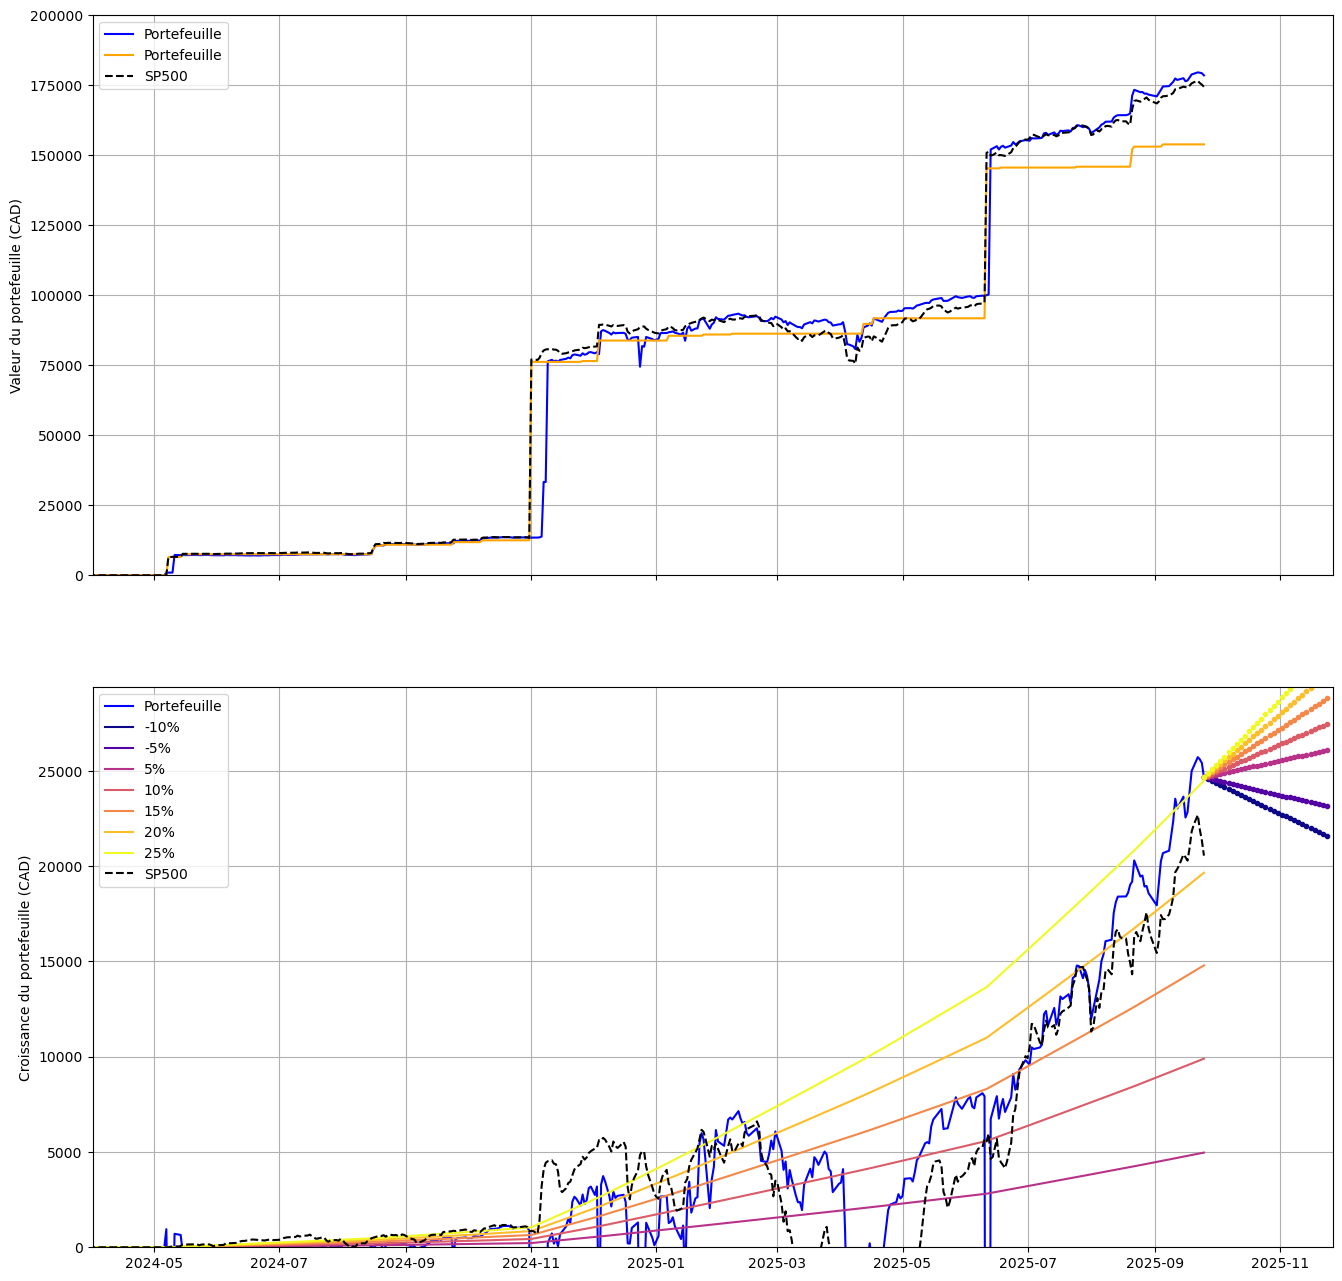

In [7]:
# Plotting the results: portfolio value, synthetic growth scenarios, and effective growth

future_projection = 31*2
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 16), sharex=True)

tbl0['time_plot'] = Time(tbl0['mjd'], format='mjd').datetime

for i in range(2):
    # Reference: 0 for absolute value, or contributions for net growth
    ref = 0 if i == 0 else tbl0['CONTRIBUTIONS']
    # Plot actual portfolio value (or value minus contributions)
    ax[i].plot(tbl0['time_plot'], tbl0['val_total'] - ref, label='Portefeuille', color='blue')

    # Use a heat palette for the synthetic growth scenarios
    norm = mcolors.Normalize(vmin=min(percent_gains), vmax=max(percent_gains))
    cmap = plt.colormaps['plasma']  # Updated to avoid deprecation warning

    if i ==1:
        for pg in percent_gains:
            color = cmap(norm(pg))
            ax[i].plot(
                tbl0['time_plot'],
                tbl0[f'growth_{pg}_percent'] - ref,
                label=f'{pg}%',
                color=color
            )

            ref0=0
            if i != 0:
                ref0 = ref[-1]

            for dt in range(0,int(future_projection),2):
                gg = (1+pg/100.0)**(dt/365.0)
                ax[i].plot(
                    tbl0['time_plot'][-1]+(dt*1.0) * TimeDelta(1, format='jd').datetime,
                    tbl0['val_total'][-1]*gg - ref0,'.',
                    color=color
                )
    else:
        #plot ref
        ax[0].plot(tbl0['time_plot'], tbl0['CONTRIBUTIONS'], label='Portefeuille', color='orange')

    # Plot the synthetic SP500 portfolio
    ax[i].plot(tbl0['time_plot'], tbl0['val_SP500'] - ref, label='SP500', color='black', linestyle='--')

# For scaling the y-axis of the second subplot
maxi = np.max(tbl0[f'growth_{pg}_percent'] - ref)

# Plot effective growth rates
#ax[2].plot(tbl0['time_plot'], tbl0['effective_growth'], label='Croissance effective', color='red')
#ax[2].plot(tbl0['time_plot'], tbl0['effective_growth_sp500'], label='Croissance effective SP500', color='orange')

# Set axis limits and labels
ax[0].set_ylim([0, 200000])
ax[1].set_ylim([0,  (maxi * 1.2)])
#ax[2].set_ylim([-25, 25])
ax[0].legend(loc = 'upper left')
ax[1].legend(loc = 'upper left')
ax[0].grid()
# set to log y scale
#ax[0].set_yscale('log')
ax[1].grid()
#ax[2].grid()
#ax[2].set_xlabel('Date')
ax[0].set_ylabel('Valeur du portefeuille (CAD)')
ax[1].set_ylabel('Croissance du portefeuille (CAD)')
#ax[2].set_ylabel('Croissance effective (%)')
ax[0].set_xlim(Time('2024-04-01', format='iso').datetime, Time.now().datetime+TimeDelta(future_projection,format='jd').datetime)
plt.show()

In [8]:
latest_portfolio = []
vv = np.zeros(len(tbl0), dtype=float)
total_last = 0.0
all_vv = []
all_valid_sym = []
for isym, sym in enumerate(symbols):
    last_quantity = tbl0[sym+'_quantity'][-1]
    if last_quantity == 0:
        continue
    last_val = tbl0[sym+'_val'][-1]
    total_last += last_val
    bt.printc(f'{sym:<10} \t {last_quantity} \t {bt.pdollar(last_val):<10}\t {last_val/last_quantity:.2f} CAD')
    if '-U' in sym:
        last_val /= tbl0['CADUSD'][-1]
    last_val = np.round(last_val, 2)
    sym = sym.replace('-U', '').replace('.TO', '')
    latest_portfolio.append((sym, last_quantity, last_val))

    tmp = np.array(tbl0[sym+'_dividend'])
    tmp/=tmp[0]
    tmp*= last_val


    all_vv.append(tmp*1.0)
    all_valid_sym.append(sym)
    vv += tmp
    print(last_val)

all_vv = np.array(all_vv).T
all_valid_sym = np.array(all_valid_sym)




16:58:51.593 |  BKCL-C     	 219 	 4 649,37$ 	 21.23 CAD
4649.37
16:58:51.594 |  CINF-C     	 9 	 266,40$   	 29.60 CAD
266.4
16:58:51.598 |  DMEC-C     	 344 	 9 487,52$ 	 27.58 CAD
9487.52
16:58:51.599 |  DRFC-C     	 846 	 33 357,78$	 39.43 CAD
33357.78
16:58:51.599 |  EBNK-C     	 1360 	 19 638,40$	 14.44 CAD
19638.4
16:58:51.602 |  ESGA-C     	 17 	 836,57$   	 49.21 CAD
836.57
16:58:51.603 |  HURA-C     	 135 	 7 755,75$ 	 57.45 CAD
7755.75
16:58:51.603 |  XUSC.U-C   	 274 	 13 401,34$	 48.91 CAD
13401.34
16:58:51.604 |  ZEA-C      	 760 	 20 653,00$	 27.17 CAD
20653.0
16:58:51.605 |  ZGQ-C      	 97 	 7 338,05$ 	 75.65 CAD
7338.05
16:58:51.605 |  ZID-C      	 134 	 6 541,88$ 	 48.82 CAD
6541.88
16:58:51.606 |  ZLU-C      	 125 	 7 230,00$ 	 57.84 CAD
7230.0
16:58:51.607 |  ZLU.U-C    	 308 	 17 814,72$	 57.84 CAD
17814.72
16:58:51.607 |  ZQQ-C      	 28 	 4 702,32$ 	 167.94 CAD
4702.32
16:58:51.608 |  ZUQ-C      	 77 	 7 221,06$ 	 93.78 CAD
7221.06
16:58:51.608 |  ZWE-C      	 4

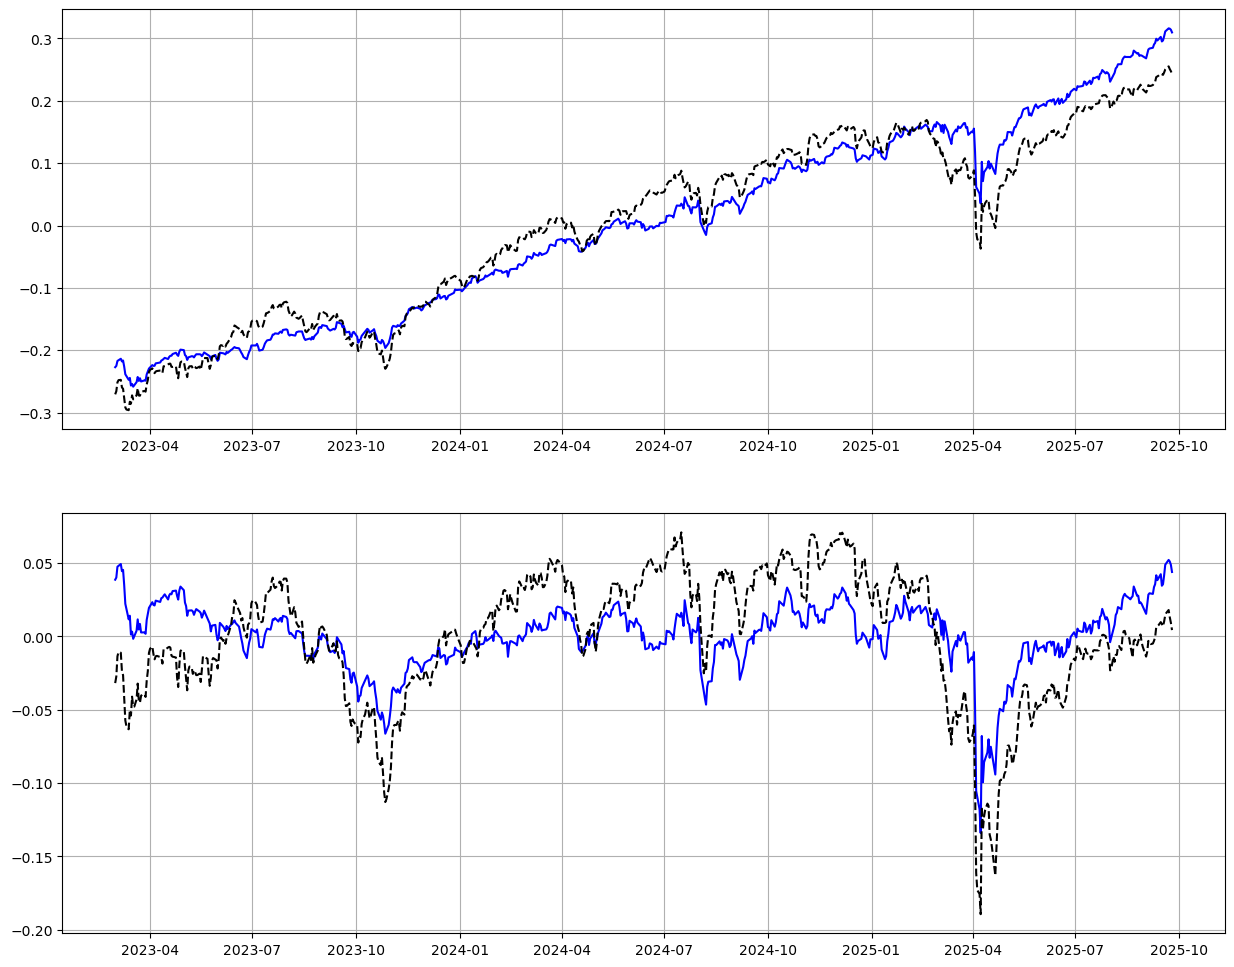

/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_26488/1337682675.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


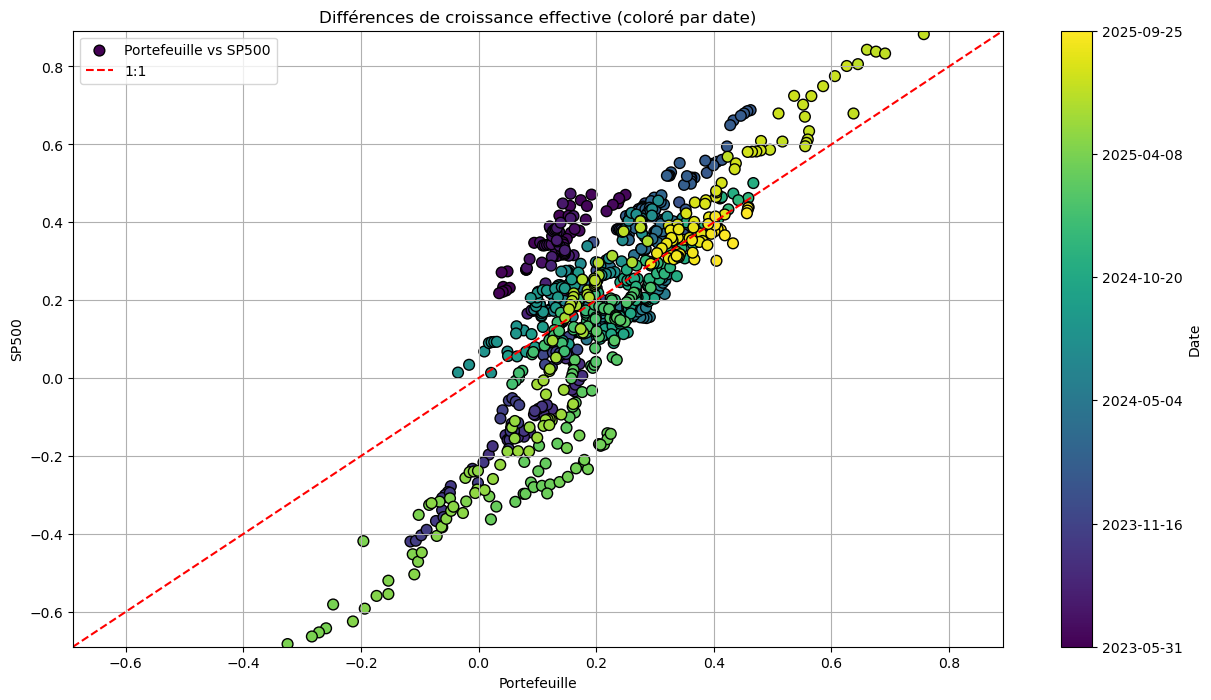

In [9]:

lvv = np.log(vv)
vv_sp500 = tbl0['SP500'] 
lvv_sp500 = np.log(vv_sp500)

fit_growth = np.polyfit(tbl0['mjd']/364.24,lvv, 1)
std_growth = np.std(lvv - (fit_growth[0] * tbl0['mjd']/364.24 + fit_growth[1]))
std_sp500 = np.std(lvv_sp500 - (np.polyfit(tbl0['mjd']/364.24,lvv_sp500, 1)[0] * tbl0['mjd']/364.24 + np.polyfit(tbl0['mjd']/364.24,lvv_sp500, 1)[1]))



fig, ax = plt.subplots(figsize=(15, 12), nrows = 2,ncols=1)
ax[0].plot(tbl0['time_plot'], np.log(vv)-np.mean(np.log(vv)), label='Portefeuille', color='blue')
ax[0].plot(tbl0['time_plot'], np.log(vv_sp500)-np.mean(np.log(vv_sp500)), label='SP500', color='black', linestyle='--')
ax[0].grid()


ax[1].plot(tbl0['time_plot'], np.log(vv) - np.polyval(np.polyfit(tbl0['mjd']/364.24, np.log(vv), 1), tbl0['mjd']/364.24), label='Portefeuille', color='blue')
ax[1].plot(tbl0['time_plot'], np.log(vv_sp500) - np.polyval(np.polyfit(tbl0['mjd']/364.24, np.log(vv_sp500), 1), tbl0['mjd']/364.24), label='SP500', color='black', linestyle='--')
ax[1].grid()


plt.show()



# find the diff histogram of vv - np.roll(vv,31)
# range from -0.2 to 0.2 in 100 bins
vmin = -1.0
vmax = 1.0
nbin = 30
nroll = 91


diff_portefeuille = lvv - np.roll(lvv, nroll)
diff_sp500 = lvv_sp500 - np.roll(lvv_sp500, nroll)
# remove elements at the beginning
diff_portefeuille = diff_portefeuille[nroll:]
diff_sp500 = diff_sp500[nroll:]

moy_portefeuille, med_portefeuille, sig_portefeuille = np.nanmean(diff_portefeuille)*(365/nroll), np.nanmedian(diff_portefeuille)*(365/nroll), np.nanstd(diff_portefeuille)
moy_sp500, med_sp500, sig_sp500 = np.nanmean(diff_sp500)*(365/nroll), np.nanmedian(diff_sp500)*(365/nroll), np.nanstd(diff_sp500)

if False:
    fig, ax = plt.subplots(figsize=(15, 5))

    ax.hist(diff_portefeuille[~np.isnan(diff_portefeuille)]*(365/nroll), bins=nbin, alpha=0.5, color='blue', label='Portefeuille', range=(vmin, vmax))
    ax.hist(diff_sp500[~np.isnan(diff_sp500)]*(365/nroll), bins=nbin, alpha=0.5, color='black', linestyle='--', label='SP500', range=(vmin, vmax))
    ax.legend()
    ax.grid()
    plt.show()


tt = tbl0['time_plot'][nroll:]

# Normalisation pour la colorisation selon le temps (tt)
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Convertir tt en valeurs numériques pour la colorisation
tt_numeric = [t.timestamp() for t in tt]
norm = mcolors.Normalize(vmin=min(tt_numeric), vmax=max(tt_numeric))
cmap = cm.get_cmap('viridis')

# Générer les couleurs pour chaque point selon tt
colors = [cmap(norm(t)) for t in tt_numeric]

fig, ax = plt.subplots(figsize=(15, 8))
# Scatter plot coloré par la date tt
ax.scatter(diff_portefeuille*(365/nroll), diff_sp500*(365/nroll), c=colors, s=60, edgecolor='k', label='Portefeuille vs SP500')

# Ligne 1-1
ax.plot([-1, 1], [-1, 1], 'r--', label='1:1')

# Limites
mini = np.minimum(np.min(diff_portefeuille*(365/nroll)), np.min(diff_sp500*(365/nroll)))
maxi = np.maximum(np.max(diff_portefeuille*(365/nroll)), np.max(diff_sp500*(365/nroll)))
ax.set_xlim([1.01*mini, 1.01*maxi])
ax.set_ylim([1.01*mini, 1.01*maxi])

ax.set_ylabel('SP500')
ax.set_xlabel('Portefeuille')
ax.set_title('Différences de croissance effective (coloré par date)')
ax.grid()
ax.legend()

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(tt_numeric)
cbar = plt.colorbar(sm, ax=ax)

import matplotlib.dates as mdates  # Remplace 'from matplotlib import mdates'
# Afficher les dates réelles sur la colorbar
date_ticks = np.linspace(min(tt_numeric), max(tt_numeric), num=6)
cbar.set_ticks(date_ticks)
from datetime import datetime

cbar.set_ticklabels([datetime.fromtimestamp(dt).strftime('%Y-%m-%d') for dt in date_ticks])

cbar.set_label('Date')

plt.show()



In [10]:

current_value = tbl0['val_total'][-1]

#input keys
keys = 'COTISATION','TRANSFERT REÇU'

keep_injection = [tbl['Type de transaction'][i] in keys for i in range(len(tbl))]

tbl = tbl[keep_injection]
# remove any USD in 'Devise du compte'
tbl = tbl[tbl['Devise du compte'] != 'USD']

tbl["Montant"] = tbl["Montant de l'opération"].astype(float)
tbl['Time_ago'] = Time.now().mjd-Time(tbl['Date de règlement']).mjd

growth_rate = -0.1

def get_current_account(growth_rate):
    return np.sum((1+growth_rate)**(tbl['Time_ago']/365.24)*tbl["Montant"])
def get_val(growth_rate):
    return np.abs(get_current_account(growth_rate)-current_value)

growth_rate = minimize(get_val,0.1).x[0]

total_cost = np.sum(tbl["Montant"])

value_sp500 =  np.sum(tbl["Montant de l'opération"]/tbl['SP500'])*sp500['Close'][-1]

current_computed = get_current_account(growth_rate)



BKCL-C     4 649,37$ CAD	 Global X Enhanced Equal Weight Canadian Banks Covered Call ETF  	 
CINF-C     266,40$ CAD	 CI Global Infrastructure Private Pool - ETF C$ Series  	 
DMEC-C     9 487,52$ CAD	 Desjardins Canadian Equity Index ETF  	 
DRFC-C     33 357,78$ CAD	 Desjardins RI Canada Multifactor - Net-Zero Emissions Pathway ETF  	 
EBNK-C     19 638,40$ CAD	 Evolve European Banks Enhanced Yield ETF Hedged CAD  	 
ESGA-C     836,57$ CAD	 BMO MSCI Canada Selection Equity Index ETF  	 
HURA-C     7 755,75$ CAD	 Global X Uranium Index ETF  	 
XUSC.U-C   13 401,34$ CAD	 iShares S&P 500 3% Capped Index ETF CAD Units  	 
ZEA-C      20 653,00$ CAD	 BMO MSCI EAFE Index ETF  	 
ZGQ-C      7 338,05$ CAD	 BMO MSCI All Country World High Quality Index ETF  	 
ZID-C      6 541,88$ CAD	 BMO MSCI India Selection Equity Index ETF  	 
ZLU-C      7 230,00$ CAD	 BMO Low Volatility US Equity ETF (CAD)  	 
ZLU.U-C    17 814,72$ CAD	 BMO Low Volatility US Equity ETF (CAD)  	 
ZQQ-C      4 702,32$ CAD	 B

/var/folders/cy/vv8rw3d12f31t1wpxpbdgmtm0000gp/T/ipykernel_26488/3751202024.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


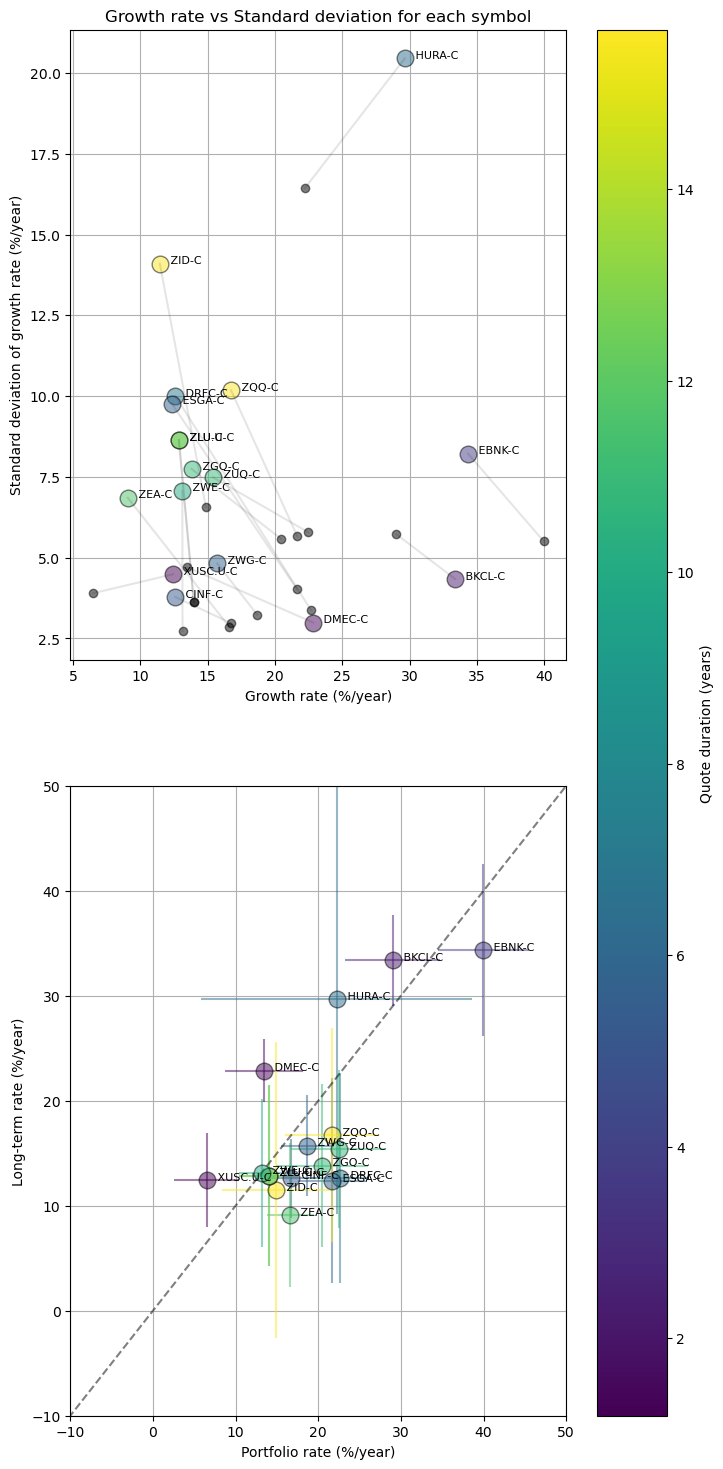

In [11]:
current_symbols = []
current_value = []
current_query_strings = []
for sym in symbols:
    v = tbl0[sym+'_val'][-1]

    if v ==0:
        continue
    if not np.isfinite(v):
        continue

    if np.abs(v)<1e-2:
        continue
    current_symbols.append(sym)
    current_value.append(v)

    info = quotes_dict[sym+'_info']
    
    print(f'{sym:<10} {bt.pdollar(v)} CAD\t {info['longName']}  \t ')

print('Delta T = ' + str(tbl0['mjd'][-1] - tbl0['mjd'][0]) + ' days')
#bt.printc('Current symbols: ' + ', '.join(current_symbols))
#print(tbl0[current_symbols[0]])

#print(current_symbols)
#print(quotes.keys())



# Get the min/max duration for color normalization
durations = []
for key in current_symbols:
    quotes = quotes_dict[key]
    duration = (quotes['mjd'][-1] - quotes['mjd'][0])/365.24  # Convert to years
    durations.append(duration)
durations = np.array(durations)
norm = plt.Normalize(vmin=np.min(durations), vmax=np.max(durations))
cmap = cm.get_cmap('viridis')

tbl_current = Table()
tbl_current['symbols'] = current_symbols
tbl_current.write('current_symbols.csv', format='csv', overwrite=True)


fig, ax = plt.subplots(figsize=(8,18), nrows = 2, ncols=1)
for idx, key in enumerate(current_symbols):
    # Fit on portfolio dividend-adjusted value
    log_div = np.log(tbl0[key+'_dividend'])
    fit = np.polyfit(tbl0['mjd']/364.24, log_div, 1)
    std = np.std(log_div - (fit[0] * tbl0['mjd']/364.24 + fit[1]))
    #bt.printc(f'{key:<10} \t {fit[0]*100.0:.2f} %/an (std: {std*100.0:.2f} %/an)')

    ax[0].plot(100*fit[0], 100*std, 'k.',alpha=0.5, markersize=12)

    slope0 = fit[0]
    sig0 = std

    # Fit on raw quotes (log_close)
    quotes = quotes_dict[key]
    fit = np.polyfit(quotes['mjd']/365.24, quotes['log_close'], 1)
    std = np.std(quotes['log_close'] - np.polyval(fit, quotes['mjd']/365.24))
    duration = (quotes['mjd'][-1] - quotes['mjd'][0])/365.24  # Convert to years
    color = cmap(norm(duration))

    #xinfo = quotes_dict[key+'_info']
    #xname = xinfo.get('name', key)
    #bt.printc(f'{key:<10} \t {fit[0]*100.0:.2f} %/an (std: {std*100.0:.2f} %/an) from quotes, duration: {duration:.2f} years')

    ax[0].plot(100*fit[0], 100*std, 'o', color=color, markersize=12, markeredgecolor='k',alpha=0.5)
    ax[0].text(100*fit[0], 100*std, '   '+key, fontsize=8)
    ax[1].text(100*slope0, 100*fit[0], '   '+key, fontsize=8)

    ax[0].plot([100*slope0, 100*fit[0]], [100*sig0, 100*std], 'k-', alpha=0.1)

    ax[1].errorbar(100*slope0, 100*fit[0], xerr = 100*sig0, yerr = 100*std, fmt='o', color=color, markersize=12, markeredgecolor='k', alpha=0.5)

#ax[0].set_yscale('log')

# Ajout d'une grille intelligente adaptée à l'échelle logarithmique
from matplotlib.ticker import LogLocator, NullFormatter

#ax[0].grid(which='major', linestyle='-', linewidth=0.7, alpha=0.5)
#ax[0].grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.3)
#ax[0].yaxis.set_major_locator(LogLocator(base=10.0, numticks=10))
#ax[0].yaxis.set_major_locator(LogLocator(base=1.0, numticks=10))
#ax[0].yaxis.set_major_locator(LogLocator(base=0.1, numticks=10))
#ax[0].yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10)*0.1, numticks=100))
#ax[0].yaxis.set_minor_formatter(NullFormatter())
# Add colorbar for duration
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Quote duration (years)')
ax[0].set_xlabel('Growth rate (%/year)')
ax[0].set_ylabel('Standard deviation of growth rate (%/year)')
ax[0].set_title('Growth rate vs Standard deviation for each symbol')


ax[1].set_ylabel('Long-term rate (%/year)')
ax[1].set_xlabel('Portfolio rate (%/year)')

ax[1].set_xlim([-10, 50])
ax[1].set_ylim([-10, 50])

# plot a 1-1 diagonal line
ax[1].plot([-100, 100], [-100, 100], 'k--', alpha=0.5)
ax[0].grid()
ax[1].grid()


plt.show()





Print last dividend distribution

In [12]:
umonth = np.unique(tbl0['Month'])

for month in umonth[-6:]:
    print(f'\nDividends for month: {month}')
    tbl1 = tbl0[tbl0['Month'] == month]

    tot = 0
    for sym in symbols:
        val_div_yield = tbl1[sym+'_div_yield']
        n_sym = tbl1[sym+'_quantity']
        total_div_yield = np.sum(val_div_yield * n_sym)
        if total_div_yield == 0:
            continue
        print(f'{sym} - {month}: {total_div_yield:.2f}$')
        tot += total_div_yield
    if tot == 0:
        continue
    print(f'Total dividends for : {tot:.2f}$\n')


Dividends for month: 2025-04
BKCL-C - 2025-04: 47.23$
EBNK-C - 2025-04: 64.96$
GEV-U - 2025-04: 5.00$
Total dividends for : 117.19$


Dividends for month: 2025-05
BKCL-C - 2025-05: 78.72$
EBNK-C - 2025-05: 108.27$
Total dividends for : 186.99$


Dividends for month: 2025-06
BKCL-C - 2025-06: 110.21$
DMEC-C - 2025-06: 100.84$
DRFC-C - 2025-06: 407.10$
EBNK-C - 2025-06: 414.31$
XUSC.U-C - 2025-06: 58.54$
ZEA-C - 2025-06: 228.00$
ZGQ-C - 2025-06: 23.28$
ZLU-C - 2025-06: 65.88$
ZLU.U-C - 2025-06: 166.32$
ZUQ-C - 2025-06: 16.94$
ZWE-C - 2025-06: 79.92$
ZWG-C - 2025-06: 75.25$
Total dividends for : 1746.59$


Dividends for month: 2025-07
BKCL-C - 2025-07: 71.86$
EBNK-C - 2025-07: 295.37$
ZWE-C - 2025-07: 41.16$
ZWG-C - 2025-07: 39.20$
Total dividends for : 447.58$


Dividends for month: 2025-08
BKCL-C - 2025-08: 118.26$
EBNK-C - 2025-08: 443.70$
ZWE-C - 2025-08: 58.92$
ZWG-C - 2025-08: 40.60$
Total dividends for : 661.48$


Dividends for month: 2025-09
BKCL-C - 2025-09: 13.14$
CINF-C - 2025

In [13]:

all_p5 = []
all_p16 = []
all_p50 = []
all_p84 = []
all_p95 = []
diffs = []
for ioff,off in enumerate([1,7,31]):

    vv1 = vv[off:]
    vv2 = vv[:-off]
    keep = vv1 != vv2
    vv1 = vv1[keep]
    vv2 = vv2[keep]
    diff = np.log(vv1) - np.log(vv2)

    diffs.append(diff)

    p5, p16, p50, p84, p95 = np.percentile(diff, [5,16,50,84,95])
    all_p5.append(p5)
    all_p16.append(p16)
    all_p50.append(p50)
    all_p84.append(p84)
    all_p95.append(p95)

current_computed = get_current_account(growth_rate)
all_p5 = np.array(all_p5)*current_computed
all_p16 = np.array(all_p16)*current_computed
all_p50 = np.array(all_p50)*current_computed
all_p84 = np.array(all_p84)*current_computed
all_p95 = np.array(all_p95)*current_computed

bt.printc('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
for idiff, diff1_tmp in enumerate(diffs):
    diff1 = diff1_tmp*1.0
    diff1 = diff1[np.argsort(diff1)]
    off = [1,7,31][idiff]
    latest = (np.log(vv[-1])-np.log(vv[-off-1]))*current_computed
    log_latest = (np.log(vv[-1])-np.log(vv[-off-1]))
    percentile_latest = np.mean(diff1<log_latest)*100.0
    bt.printc(f'Latest growth for {off} days: {latest:.2f}$ ({log_latest*100:.2f}%, percentile: {percentile_latest:.1f}%)')
bt.printc('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
bt.printc('Percentiles of log growth over day/week/month periods:')
bt.printc('5th percentiles:\t ' + '\t '.join([bt.pdollar(x) for x in all_p5]))
bt.printc('16th percentiles:\t ' + '\t '.join([bt.pdollar(x) for x in all_p16]))
bt.printc('50th percentiles:\t ' + '\t '.join([bt.pdollar(x) for x in all_p50]))
bt.printc('84th percentiles:\t ' + '\t '.join([bt.pdollar(x) for x in all_p84]))
bt.printc('95th percentiles:\t ' + '\t '.join([bt.pdollar(x) for x in all_p95]))



# ...existing code...
bt.printc('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

bt.printc(f'Analyse du portefeuille au {Time.now().iso[:10]}')
bt.printc(f'Statistiques basées sur la croissance sur des périodes de {nroll} jours')
bt.printc(f'Portefeuille : Moyenne={moy_portefeuille*100:.2f}%/an, Médiane={med_portefeuille*100:.2f} %/an, Écart-type={sig_portefeuille*100:.2f} %/an')
bt.printc(f'SP500 : Moyenne={moy_sp500*100:.2f}%/an, Médiane={med_sp500*100:.2f} %/an, Écart-type={sig_sp500*100:.2f} %/an\n')

bt.printc(f'Statistiques sur la pente de la croissance effective des actions détenues (dividendes réinvestis)')

bt.printc(f'Croissance moyenne effective : {fit_growth[0]*100.0:.2f} %/an (écart-type : {std_growth*100.0:.2f} %/an)')
bt.printc(f'Croissance moyenne effective SP500 : {np.polyfit(tbl0["mjd"]/364.24,np.log(vv_sp500), 1)[0]*100.0:.2f} %/an (écart-type : {std_sp500*100.0:.2f} %/an)\n')

bt.printc(f'Total des investissements')
bt.printc(f'Actuel : {bt.pdollar(np.sum(current_value))}')
bt.printc(f'Coût total : {bt.pdollar(total_cost)}')
bt.printc(f'Gain total : {bt.pdollar(np.sum(current_value) - total_cost)}\n')
bt.printc(f'Croissance effective actuelle\n')
bt.printc(f'Taux de croissance actuel : {100*growth_rate:.2f}%')

bt.printc(f'Taux de croissance annuel : {bt.pdollar(current_computed*growth_rate)}/an')
bt.printc(f'Par 2 semaines : {bt.pdollar(current_computed*growth_rate/26.09)}/paie')

bt.printc(f'Taux de croissance quotidien (250 jours/an) : {bt.pdollar(current_computed*growth_rate/250)}/jour')
bt.printc(f'Taux de croissance quotidien (365 jours/an) : {bt.pdollar(current_computed*growth_rate/365)}/jour\n')

bt.printc(f'Dernière valeur du SP500 : {bt.pdollar(sp500["Close"][-1])}')
bt.printc(f'Valeur si tout était investi dans le SP500 : {bt.pdollar(value_sp500)}')
# ...existing code...

16:58:53.463 |  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
16:58:53.464 |  Latest growth for 1 days: -771.53$ (-0.43%, percentile: 9.2%)
16:58:53.465 |  Latest growth for 7 days: 1108.00$ (0.62%, percentile: 53.4%)
16:58:53.466 |  Latest growth for 31 days: 6034.97$ (3.38%, percentile: 77.3%)
16:58:53.466 |  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
16:58:53.467 |  Percentiles of log growth over day/week/month periods:
16:58:53.467 |  5th percentiles:	 -1 070,15$	 -2 794,52$	 -3 307,42$
16:58:53.468 |  16th percentiles:	 -443,07$	 -1 245,90$	 -739,99$
16:58:53.469 |  50th percentiles:	 103,26$	 972,09$	 3 830,09$
16:58:53.469 |  84th percentiles:	 662,28$	 2 588,13$	 6 849,46$
16:58:53.470 |  95th percentiles:	 1 330,92$	 4 075,32$	 9 555,13$
16:58:53.470 |  ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

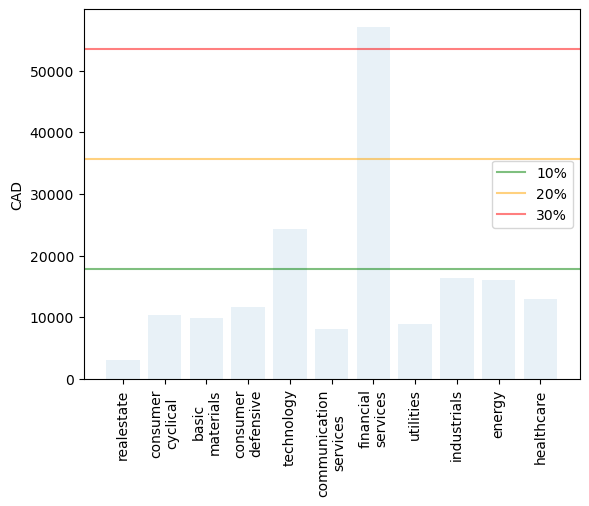

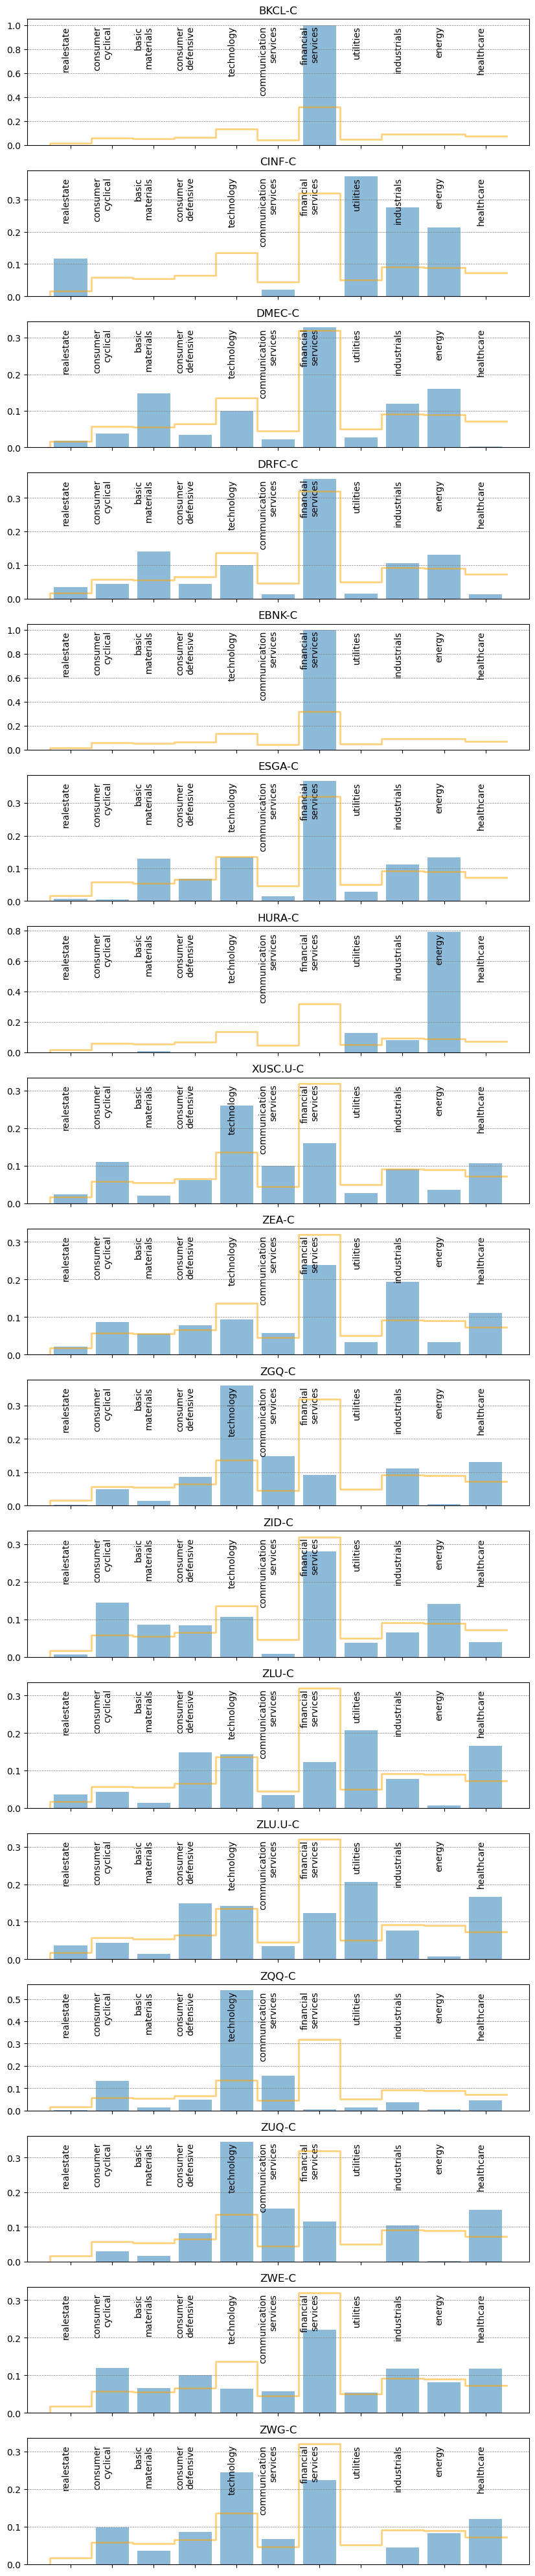

In [14]:
s = np.zeros(11)

dict_sectors = dict()
for idx, key in enumerate(all_valid_sym):
    key2 = key.replace('.U', '')
    sector_data = bt.sectors(dict_symbols[key2])
    s+=sector_data['frac']*current_value[idx]

    dict_sectors[key] = sector_data

sectors = sector_data['sector']
sectors = [s.replace('_', '\n') for s in sectors]

plt.bar(sectors, s, alpha=0.1)
# barre horizontable à 10, 20, 30% du total the s
s_total = np.sum(s)
colors = ['gray','green','orange','red']
for i in range(1,4):
    plt.axhline(i*0.1*s_total, alpha=0.5, label=f'{i*10}%', color = colors[i])
plt.legend()
plt.xticks(rotation=90)
plt.ylabel('CAD')
plt.show()


fig, ax = plt.subplots(figsize=(10, 3*len(dict_sectors)), nrows=len(dict_sectors), ncols=1)

for idx, key in enumerate(all_valid_sym):
    key2 = key.replace('.U', '')
    sector_data = dict_sectors[key]
    ax[idx].bar(sector_data['sector'], sector_data['frac'], alpha = 0.5)
    sectors = sector_data['sector']
    # replace _ with \c
    sectors = [s.replace('_', '\n') for s in sectors]
    avg = s/np.sum(s)
    # Use integer positions for stair-step, extend -0.5 and +0.5
    x = np.arange(len(sectors))
    x_step = np.concatenate(([x[0]-0.5], x+0.5))
    y_step = np.concatenate(([0], avg, [0]))
    ax[idx].step(x_step, np.concatenate(([0], avg)), color='orange', linewidth=2, where='pre', label='Portfolio average', alpha=0.5)
    ax[idx].set_xticks(x)
    ax[idx].set_xticklabels(sectors, rotation=90)
    ax[idx].set_title(key)
    # Place xticklabels at the top, inside the plot
    ax[idx].set_xticklabels(sectors, rotation=90, ha='right', va='top')

    bbox = ax[idx].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    height_inch = bbox.height
    pad_pts = height_inch * fig.dpi*0.7  # Convert inches to points

    ax[idx].tick_params(axis='x', pad=-pad_pts)  # Negative pad moves labels inside the plot from the top
    #if idx != len(all_valid_sym) - 1:
    #    ax[idx].set_xticklabels([])

    ax[idx].grid(color = 'gray', linestyle = '--', linewidth = 0.5, axis='y')
plt.show()